# Machine learning models to classify methylation from MSC $p$-values

> Christopher Kimmel | 9/4/2020
>
> kimmel.95@osu.edu

This notebook writes and evaluates several machine-learning classifiers to identify whether HIV strands are m6A modified at zero-based nucleotide position 8078.
Reads with known modification status were sequenced in an ONT Min-ION device, then $p$-values were extracted using Tombo's `model_sample_compare` (MSC) feature with `fisher_context=0`.
The resulting $p$-values are stored in the CSV files in this directory.

What I just wrote is probably gibberish to people outside our lab. If you're reading this and you have any questions at all, please email me at kimmel.95@osu.edu. I like emails from non-robots.

## To-do
- [ ] Move dropna to the beginning

## Table of Contents
* [Load Training Data](#load_training_data)
* [Explore Training Data](#explore_training_data)
* [Configure Training and Testing Framework](#configure_training_and_testing_framework)
* [Design Models](#design_models)
* [Test Models](#test_models)

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.decomposition
import sklearn.svm
import sklearn.preprocessing

import matplotlib.pyplot as plt
import matplotlib.lines
import seaborn as sns
sns.set()

## Load Training Data<a name="load_training_data"></a>

In [80]:
paths = {'pos': '082720_8079m6A_positive_fishers0.csv',
         'neg': '082720_8079m6A_negative_fishers0.csv',
         'Trizol_OLD' : '/fs/project/PAS1405/kimmel_out/varied_fisher/1/fisher_0.tombo.per_read_stats.csv',
         'f1f2' : '/fs/project/PAS1405/kimmel_out/varied_fisher/2/f1f2_subsampled_fisher_0.tombo.per_read_stats.csv'
        }

# New code
tables_dropnaed = {}
for key, path in paths.items():
    print(f'loading {path}')
    tables_dropnaed[key] = pd.read_csv(
        paths[key],
        header=0,
        index_col=0,
        usecols=['read_id'] + [str(x) for x in range(8071, 8080+1)], # only extract the columns we need
    ).dropna()
#    tables_dropnaed[key].columns = map(
#        (lambda x: int(x) if x.isdecimal() else x), # Sorry
#        tables[key].columns,
#    )

# Old code
tables = {}
for key, path in paths.items():
    tables[key] = pd.read_csv(
        paths[key],
        header=0,
        index_col=0,
        usecols=['read_id'] + [str(x) for x in range(8071, 8080+1)], # only extract the columns we need
    )
    tables[key].columns = map(
        (lambda x: int(x) if x.isdecimal() else x), # Sorry
        tables[key].columns,
    )

loading 082720_8079m6A_positive_fishers0.csv
loading 082720_8079m6A_negative_fishers0.csv
loading /fs/project/PAS1405/kimmel_out/varied_fisher/1/fisher_0.tombo.per_read_stats.csv
loading /fs/project/PAS1405/kimmel_out/varied_fisher/2/f1f2_subsampled_fisher_0.tombo.per_read_stats.csv


In [82]:
for name, tab in tables_dropnaed.items():
    print(name)
    display(tab.head())

pos


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206


neg


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
00a0a871-6886-45c8-a6b9-65d0ba800069,0.720210,0.789149,0.420912,0.087897,0.272514,5.317310e-01,0.661067,0.609795,0.045854,0.657107
00ecb296-3580-4d75-9d1f-a6b6fedc3e01,0.549433,0.776922,0.286839,0.978955,0.351899,9.126486e-01,0.380977,0.566955,0.298615,0.719023
012e93bb-1005-4f3b-93fd-1ea1e47ffe47,0.743258,0.264297,0.768545,0.358252,0.476503,1.423748e-01,0.160891,0.362595,0.144221,0.000053
01b83cf0-0d78-453a-8e6a-e6b2187fd32f,0.580595,0.665775,0.010144,0.758974,0.300949,7.496507e-01,0.181335,0.632513,0.076767,0.937543
01c5c647-deb2-4144-8d64-baafb7d258ad,0.490944,0.895945,0.749461,0.415461,0.127709,3.200000e-17,0.736028,0.925196,0.740035,0.520994


Trizol_OLD


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
00676bde-4b93-45bb-a850-c333e08c9927,0.532200,0.665427,0.678478,0.547065,0.092869,0.000484,0.042387,0.498844,0.108770,0.829916
009fd00a-a238-426b-a768-5ccff88e9e3d,0.553935,0.894675,0.337661,0.376462,0.394596,0.004213,0.114751,0.552572,0.619290,0.941568
00a393dd-8fca-411a-9fef-c6da3712339b,0.953388,0.771212,0.990897,0.326374,0.205801,0.468165,0.417321,0.909635,0.284905,0.915740
00b6fee3-c8d3-4fcf-9a76-3d39d7f1a14f,0.000109,0.986279,0.311922,0.284982,0.280849,0.024179,0.214000,0.332598,0.308457,0.562858
00bc4e9f-bc03-46b2-b1c9-bf99aa2021d2,0.320648,0.623505,0.949723,0.212934,0.525950,0.626632,0.609795,0.712709,0.076734,0.962698


f1f2


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
0012a9ed-268f-47af-aec5-d1ea71e2b235,0.019727,0.739870,0.170365,0.898909,0.372158,0.783309,0.416172,2.236787e-07,0.915802,0.774555
004b868e-e588-4562-8869-65620d5b93db,0.388751,0.668167,0.360188,0.756013,0.458092,0.404007,0.923377,1.684743e-01,0.055183,0.986992
0067d501-34d0-416d-85eb-6c9ac788b83d,0.598880,0.988737,0.451638,0.458173,0.973088,0.650490,0.487404,9.289784e-01,0.395905,0.954731
0068da9d-22ca-4273-a656-5a71acce6079,0.358695,0.268689,0.847203,0.676655,0.879443,0.469454,0.231389,7.861659e-01,0.847901,0.916164
00773c2c-c456-4b64-8e2c-310acd91ffb7,0.803860,0.069822,0.355055,0.728603,0.676451,0.398965,0.435421,6.060473e-02,0.144073,0.778791


In [154]:
# new code
n = len(tables_dropnaed['pos'])
index = tables_dropnaed['pos'].index
pos_labels = pd.Series(np.full((n,), 1, int), index=index)

n = len(tables_dropnaed['neg'])
index = tables_dropnaed['neg'].index
neg_labels = pd.Series(np.full((n,), 0, int), index=index)

training_labels = pd.concat([pos_labels, neg_labels])
display(training_labels)

# old code
tables['pos']['mod'] = 1
tables['neg']['mod'] = 0
table = pd.concat(tables.values())

read_id
001049b1-b30e-4442-b12e-af4ffb502dd0    1
00bb1e66-ae04-48f1-a406-811c47a1c895    1
0126a6dc-156e-4621-af1e-f032869dc80b    1
022c5d7e-be67-4dd5-8766-b7272e09ac89    1
0239fb65-639f-4206-99af-d1955c242ceb    1
                                       ..
fe7485a6-2e66-47f1-815b-972bd583aca4    0
fecaaa10-576c-4889-b76d-8e3bb1a68792    0
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1    0
ffc723d2-5a45-44fe-b2d0-530554eb6f09    0
ffec333d-c008-4948-a88b-70385772d067    0
Length: 1350, dtype: int64

In [155]:
display(table)

,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,mod
read_id,,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456,1.0
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183,1.0
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660,1.0
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817,1.0
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206,1.0
...,...,...,...,...,...,...,...,...,...,...,...
ffe2923f-4e78-456a-9b6b-5ab690c857a3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffe7c4ec-6a7d-4a5d-a7c0-5bb2d71dd0e8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffec2431-796d-4d07-8a91-245ca82ac1fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
x = table.drop('mod', axis=1)
y = table['mod']
print('x')
display(x.sample(7))
print('y')
display(y.sample(7))

x


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
db76239b-fe40-4fa6-9771-0c525babae67,0.535501,0.623014,0.544616,0.323806,0.980377,0.478160,0.414709,0.915454,0.644380,0.984780
f3f7f9b8-b803-4519-8cf9-f4ddaa5074ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1cd65c04-2ff8-488b-8b57-6446f05fff45,0.751657,0.722537,0.499950,0.549376,0.640434,0.715240,0.728994,0.660502,0.312160,0.884283
502a627f-4986-48bb-a54f-f7fe0340e8f4,0.749720,0.739478,0.672400,0.544793,0.504966,0.559093,0.480732,0.894610,0.801908,0.812813
d09b6f7e-b814-4b80-a9f8-b3b697a7adff,0.691252,0.934030,0.831060,0.957363,0.868522,0.969083,0.929807,0.293399,0.058558,0.797561
17e15b1a-2c87-4e69-8dc7-40dbf4658b69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62766938-56b1-4dd6-8839-6a128d945774,0.864908,0.197085,0.777133,0.744794,0.830934,0.868571,0.755327,0.317336,0.055003,0.002362


y


read_id
bdf63520-48d6-4082-8c61-0e2cf337bc8c   NaN
863ea653-677f-460e-bd05-cbba7e819be6   NaN
a9f7e428-0ac6-4aef-ae2d-862ca5c12f3a   NaN
ac17c2cf-285a-4dd2-94c4-f44db0a36ce9   NaN
fff5f836-621a-4de7-934d-0b233605743a   NaN
ed9fa3a5-a697-4536-96e0-3dc5b2b4c503   NaN
14ebc9a4-bbd4-4bea-a12e-cc56bcd8c233   NaN
Name: mod, dtype: float64

## Explore Training Data<a name='explore_training_data'>

Reduce to two dimensions with PCA and plot with two colors.

In [157]:
to_plot = table[list(range(8074, 8080+1)) + ['mod']].sample(frac=0.1)

/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


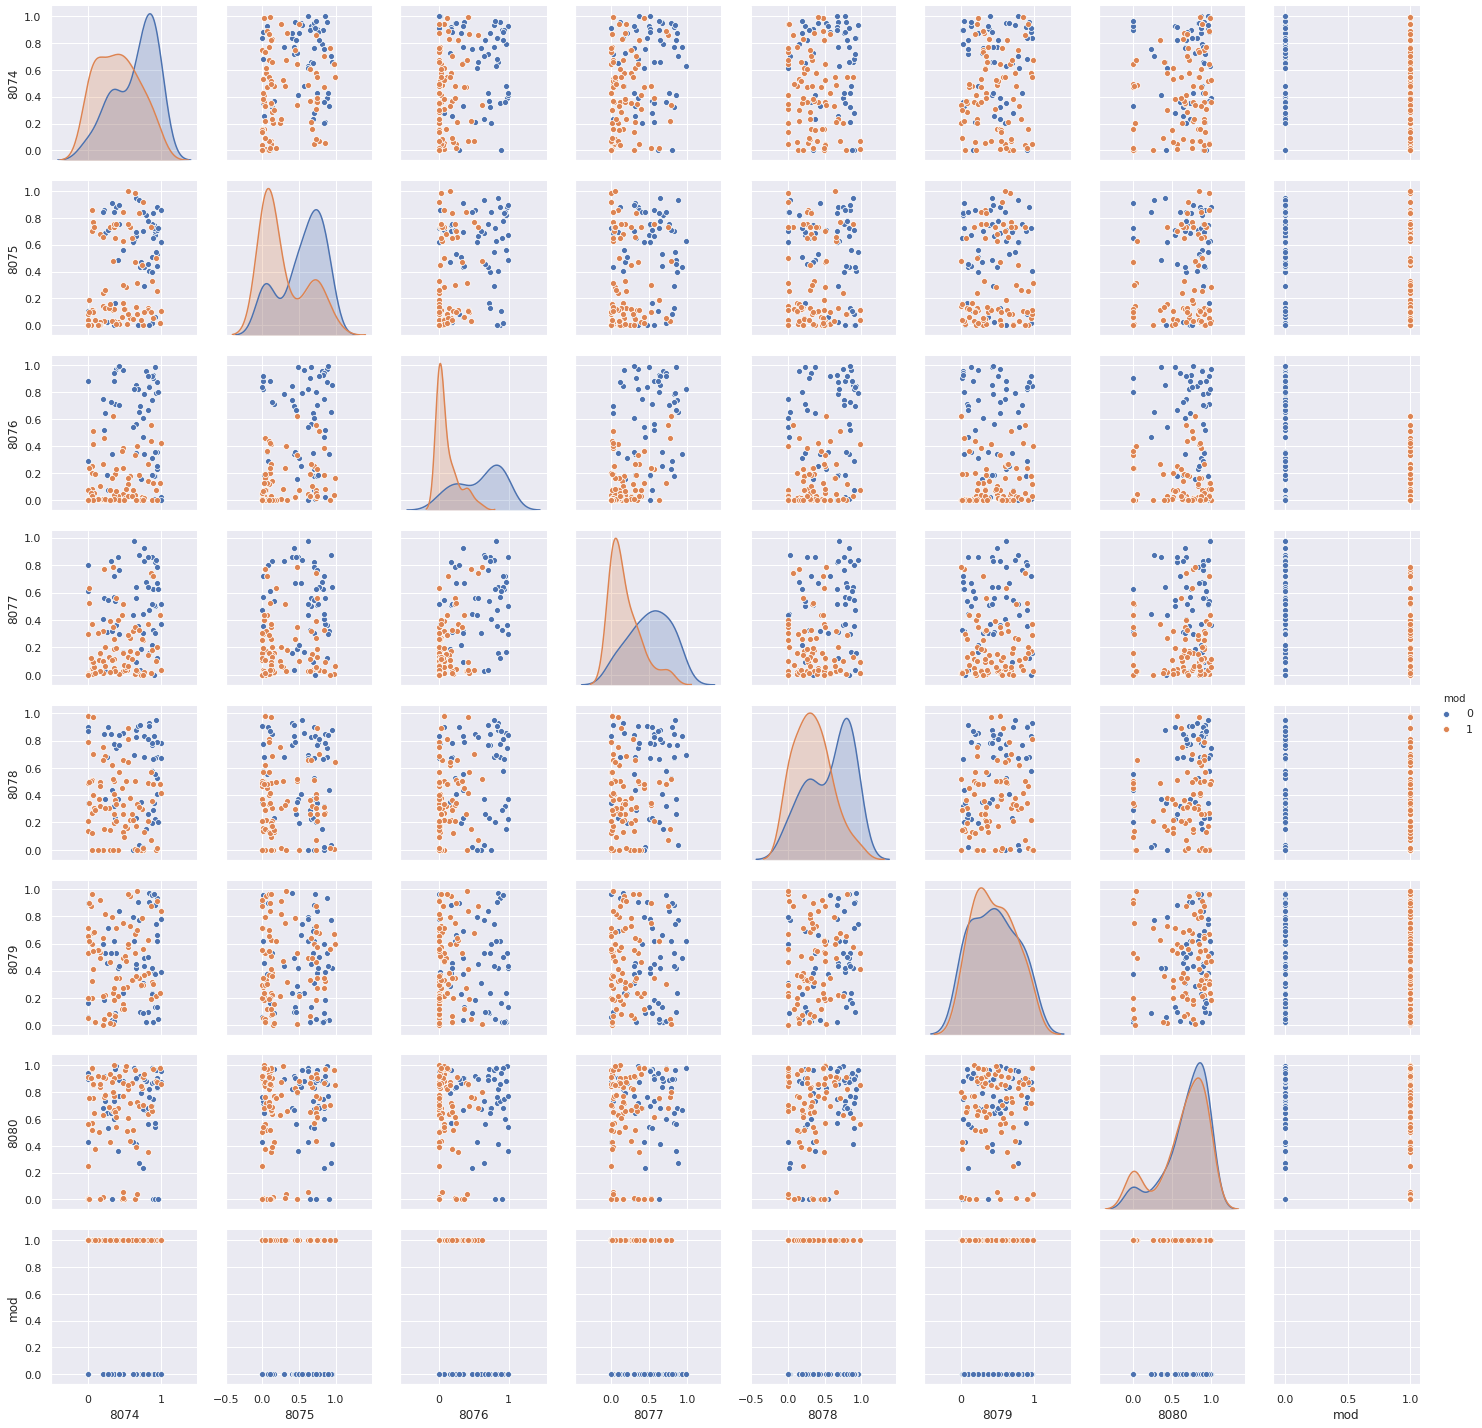

In [8]:
sns_plot = sns.pairplot(to_plot, hue='mod')
sns_plot.savefig('pairplot.png')

Log-scaling the data makes the explained-variance ratio higher with fewer components.
I guess that makes sense.

In [9]:
pca_model = sklearn.decomposition.PCA()
pca_fitted = pca_model.fit(x.dropna())

In [10]:
pca_fitted.explained_variance_ratio_.cumsum()

array([0.23543922, 0.3480352 , 0.4554045 , 0.55365289, 0.64518722,
       0.72838537, 0.80675856, 0.8775473 , 0.9452154 , 1.        ])

In [11]:
mean = x.dropna().values.mean(axis=0) # + pca_fitted.components_[0]

print('\t'.join(['pos','mean','comp1','comp2','comp3']))
for pos, mean_entry, *comps in zip(x.columns, mean, *pca_fitted.components_[0:3]):
    print('\t'.join(['{}'] + 4*['{: 0.1f}']).format(pos, mean_entry, *comps)) #  '{}\t{: .3f}\t{: .3f}\t{: .3f}'.format(pos, mean_entry, comp1, comp2))

pos	mean	comp1	comp2	comp3
8071	 0.5	-0.1	-0.4	-0.2
8072	 0.5	-0.1	-0.5	-0.4
8073	 0.5	-0.1	-0.4	 0.3
8074	 0.5	-0.4	-0.4	 0.2
8075	 0.4	-0.5	-0.2	 0.3
8076	 0.3	-0.5	 0.3	 0.1
8077	 0.4	-0.5	 0.2	 0.1
8078	 0.5	-0.3	 0.3	-0.3
8079	 0.5	-0.2	 0.0	-0.5
8080	 0.7	-0.1	-0.1	-0.4


In [12]:
# sandbox
pca_transformed = (
    pd.DataFrame(
        pca_fitted.transform(x.dropna()),
        index=x.dropna().index
    )
    .rename_axis('comp', axis=1)
)
pca_transformed

comp,0,1,2,3,4,5,6,7,8,9
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.218540,-0.560251,0.156105,0.346829,-0.037261,-0.131526,-0.437607,0.000742,-0.023130,-0.304126
00bb1e66-ae04-48f1-a406-811c47a1c895,0.168590,0.717854,-0.196540,-0.038905,-0.327762,-0.419545,0.229060,-0.134948,0.568521,0.512923
0126a6dc-156e-4621-af1e-f032869dc80b,0.392858,0.110214,-0.000790,-0.079940,-0.649848,-0.164749,0.091374,0.079968,-0.379810,-0.014173
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.097172,-0.148933,-0.291341,0.305359,-0.134769,0.117430,-0.097639,-0.184588,-0.337408,-0.306514
0239fb65-639f-4206-99af-d1955c242ceb,0.108812,0.011268,0.296537,-0.166864,-0.684594,-0.124335,-0.368048,-0.093137,0.101924,-0.305837
...,...,...,...,...,...,...,...,...,...,...
fe7485a6-2e66-47f1-815b-972bd583aca4,0.074544,0.139445,0.313241,0.253494,-0.215110,-0.285212,-0.293045,0.097268,-0.194516,0.383393
fecaaa10-576c-4889-b76d-8e3bb1a68792,-0.428155,0.149626,0.230869,0.018892,-0.032165,0.375375,-0.106265,-0.035186,-0.225178,0.702460
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1,-0.529495,0.025623,0.208068,0.055336,0.109408,0.178736,-0.067634,0.230077,0.204772,-0.383968


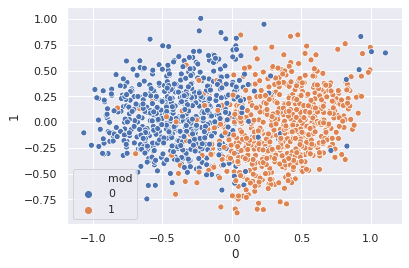

In [13]:
sns.scatterplot(
    x=pca_transformed[0],
    y=pca_transformed[1],
    hue=y # y is the "target" series of correct labelings
)

Do some logistic regression. (TLS? OLS? GLS?)
Maybe even test for normality.
Plot the first two dimension

## Configure Training and Testing Framework<a name='configure_training_and_testing_framework'>

In [158]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    table.dropna().drop('mod', axis=1), table.dropna()['mod'], test_size=0.5, random_state=855
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(675, 10) (675, 10) (675,) (675,)


## Early model training

In [159]:
svm_model_linear = sklearn.svm.LinearSVC(
    penalty = 'l2',
    dual = True
)
svm_model_linear.fit(x_train, y_train)
prediction = svm_model_linear.predict(x_test)
print('error rate on test set: {:.1%}'
      .format(np.count_nonzero(prediction - y_test) / len(y_test))
     )

error rate on test set: 9.8%


Evidently the best we can do with a linear SVM is about 90% accuracy.
I'm curious what kind of accuracy we could expect from a $p$-value cutoff at just the one position.

Here's a picture.

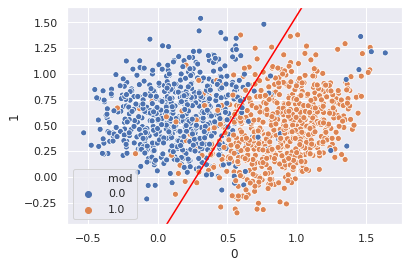

In [160]:
ax = sns.scatterplot(
    x=mean[0]+pca_transformed[0],
    y=mean[1]+pca_transformed[1],
    hue=y # y is the "target" series of correct labelings
)
co_0 = svm_model_linear.coef_[0,0]*100
co_1 = svm_model_linear.coef_[0,1]*100
b = 1/svm_model_linear.intercept_
ax.add_line(matplotlib.lines.Line2D([b-co_0,b+co_0],[b-co_1,b+co_1], color='red'))

In [23]:
# svm_model.coef_
svm_model_linear.intercept_

array([0.02734388])

Here's a nonlinear SVC. None of the kernels improve accuracy significantly, but RBF helps a little. (Note you have to scale your data before using sklearn nonlinear SVMs.)

In [47]:
'''
scaler = sklearn.preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(table.dropna().drop('mod', axis=1))
scaled_y = table.dropna()['mod']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    scaled_x, scaled_y, test_size=0.5, random_state=855
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
'''

(675, 10) (675, 10) (675,) (675,)


In [51]:
'''
svm_model_rbf = sklearn.svm.SVC(
    kernel = 'rbf'
)
svm_model_rbf.fit(x_train, y_train)
prediction = svm_model_rbf.predict(x_test)
print('error rate on test set: {:.1%}'
      .format(np.count_nonzero(prediction - y_test) / len(y_test))
     )
'''

error rate on test set: 8.7%


/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Trying model on other datasets

Now we'll take the model we trained on the labeled positive and negative control data and run it on Trizol_OLD and f1f2.

In [171]:
predictions = {}
for name, tab in tables_dropnaed.items():
    print(f'computing predictions for {name}')
    prediction = pd.Series(svm_model_linear.predict(tab), index=tab.index, dtype=int)
    predictions[name] = prediction

computing predictions for pos
computing predictions for neg
computing predictions for Trizol_OLD
computing predictions for f1f2


In [172]:
for name, tab in predictions.items():
    print(f'Dataset: {name}')
    fraction_pos = tab.sum()/len(tab)
    print(f'Fraction of reads classified as "pos": {fraction_pos:.4f}')
    print()

Dataset: pos
Fraction of reads classified as "pos": 0.9195

Dataset: neg
Fraction of reads classified as "pos": 0.0935

Dataset: Trizol_OLD
Fraction of reads classified as "pos": 0.5207

Dataset: f1f2
Fraction of reads classified as "pos": 0.1140



In [178]:
for name, tab in predictions.items():
    tab.to_csv('./output_summaries/{name}_classifier_predictions')

/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  from ipykernel import kernelapp as app
